# Neuroscope
Generating horoscope-like tweets with different implementations of RNN

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import twitter as twt
import seaborn as sns
import codecs as cdc
import pickle
import nltk
import pymorphy2
import itertools
import string
import os
import random as rnd
from collections import Counter, deque
from sklearn.manifold import TSNE, MDS

sns.set_style('whitegrid')
sns.despine()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Acquire corpus
---
Initialize Twitter client

In [ ]:
API_KEY = os.environ.get('TWITTER_API_KEY', '')
API_SECRET = os.environ.get('TWITTER_API_SECRET', '')
BEARER_TOKEN = twt.oauth2_dance(API_KEY, API_SECRET)
t = twt.Twitter(auth=twt.OAuth2(bearer_token=BEARER_TOKEN))

Download data

In [2]:
accounts = np.array(['gor_aries', 'gor_taurus', 'gor_gemini', 'gor_cancer', 'gor_leo', 'gor_virgo', \
                     'gor_libra', 'gor_scorpio', 'gor_sagittarius', 'gor_aquarius', \
                     'gor_pisces'])
names = np.array(['Овен', 'Телец', 'Близнецы', 'Рак', 'Лев', 'Дева', 'Весы', 'Скорпион', 'Стрелец', \
                  'Водолей', 'Рыбы'])

In [3]:
def download_data(accounts, filename='raw'):
    print 'Downloading data'
    raw = []

    for account in accounts:
        print '-> Processing account %s' % account
        max_id = 0
        tweets = []

        if not os.path.isfile('./raw_%s' % account):
            print '--> Receiving tweets'
            part = t.statuses.user_timeline(screen_name=account, include_rts='false', exclude_replies='true')
            for tweet in part:
                tweets.append(tweet)
            old_max_id = max_id
            max_id = tweets[len(tweets)-1]['id']

            while old_max_id != max_id:
                part = t.statuses.user_timeline(screen_name=account, 
                                                include_rts='false', exclude_replies='true', max_id=max_id, timeout=1)
                for tweet in part:
                    tweets.append(tweet)
                old_max_id = max_id
                max_id = tweets[len(tweets)-1]['id']
            print '--> Received %d tweets' % len(tweets)

            with open('raw_%s' % account, 'w') as fout:
                pickle.dump(tweets, fout)
            print '--> Dumped tweets'
        else:
            with open('raw_%s' % account, 'r') as fin:
                tweets = pickle.load(fin)
            print '--> Loaded previously dumped %d tweets' % len(tweets)
        
        tweets = [tweet['text'] for tweet in tweets]
        for tweet in tweets:
            raw.append(tweet)
        del tweets

    with open(filename, 'w') as fout:
        pickle.dump(raw, fout)
    del raw

Loading data

In [4]:
def load_data(filename='./raw', load=False):
    print 'Reading data'
    
    words = []
    tokenized = []
    
    if not load:
        print '-> With preprocesing'
        with open(filename, 'r') as fin:
            tweets = pickle.load(fin)

        morph = pymorphy2.MorphAnalyzer()

        for tweet in tweets:
            result = [u'<$>']
            tweet = nltk.word_tokenize(tweet.lower())
            tweet = [w for w in tweet if w not in string.punctuation]
            tweet = [morph.parse(w)[0].normal_form for w in tweet]
            tweet.append(u'<#>')
            result.extend(tweet)
            tokenized.append(result)
            words.extend(result)

        with open('words', 'w') as fout:
            pickle.dump(words, fout)

        with open('tweets', 'w') as fout:
            pickle.dump(tweets, fout)
    else:
        print '-> Previously processed'
        with open('words', 'r') as fin:
            words = pickle.load(fin)

        with open('tweets', 'r') as fin:
            tokenized = pickle.load(fin)
    
    return tokenized, words

In [5]:
def build_dataset(dataset, words, vocabulary_size=None):
    word_to_index = {}
    index_to_word = {}
    word_count = []
    
    word_count.extend(Counter(words).most_common(vocabulary_size))
    print 'Most common word is %s with %d times' % (word_count[0][0], word_count[0][1])
    print 'Least common word is %s with %d times' % (word_count[len(word_count)-1][0], word_count[len(word_count)-1][1])
    
    for word, _ in word_count:
        word_to_index[word] = len(word_to_index)
    
    for word in words:
        index = word_to_index[word]
        dataset.append(index)
    
    index_to_word = dict(zip(word_to_index.values(), word_to_index.keys()))
    permutation = np.random.permutation(dataset)
    data = [word_to_index[w] for w in words]
    
    return permutation, data, word_count, word_to_index, index_to_word

In [6]:
# download_data(accounts)
# nltk.download()
tweets, words = load_data(load=True)

Reading data
-> Previously processed


In [7]:
permutation, data, word_count, word_to_index, index_to_word = build_dataset(tweets, words)
vocabulary_size = len(word_count)
print 'Using vocabulary size %d' % vocabulary_size

Most common word is <$> with 24058 times
Least common word is собранный with 2 times
Using vocabulary size 4266


Эмбеддинг
---
Using CBoW

In [8]:
data_index = 0

def generate_embedding_batch(words, batch_size, window_size):
    global data_index
    
    batch = np.ndarray(shape=(batch_size, 2 * window_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * window_size + 1
    
    buf = deque(maxlen=span)
    for _ in range(span):
        buf.append(words[data_index])
        data_index = (data_index + 1) % len(words)
        
    for i in range(batch_size):
        target = window_size
        
        for j in range(window_size):
            batch[i][j] = buf[j]
        labels[i] = buf[target]
        buf.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [9]:
batch_size = 128
window_size = 2
embedding_size = 256
valid_size = 16
valid_window = 100
num_sampled = 64
valid_examples = np.array(rnd.sample(range(valid_window), valid_size))

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * window_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model
    embed = []
    for i in range(window_size):
        embed.append(tf.nn.embedding_lookup(embeddings, train_dataset[:, i]))
    embed = tf.reduce_sum(embed, axis=0)
    # logits = tf.matmul(embed, tf.transpose(softmax_weights)) + softmax_biases
    # probs = tf.nn.softmax(logits)
    # loss = - tf.reduce_sum(tf.log(probs))
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                     labels=train_labels, num_sampled=num_sampled, 
                                                     num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [10]:
num_steps = 100001

if not os.path.isfile('./embedding'):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_embedding_batch(data, batch_size, window_size)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 5000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = index_to_word[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = index_to_word[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        final_embeddings = normalized_embeddings.eval()
        with open('embedding', 'w') as fout:
            pickle.dump(final_embeddings, fout)
else:
    with open('embedding', 'r') as fin:
        final_embeddings = pickle.load(fin)

In [11]:
num_points = 400

if not os.path.isfile('./2d_embeddings'):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    my_two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
else:
    with open('./2d_embeddings', 'r') as fin:
        my_two_d_embeddings = pickle.load(fin)

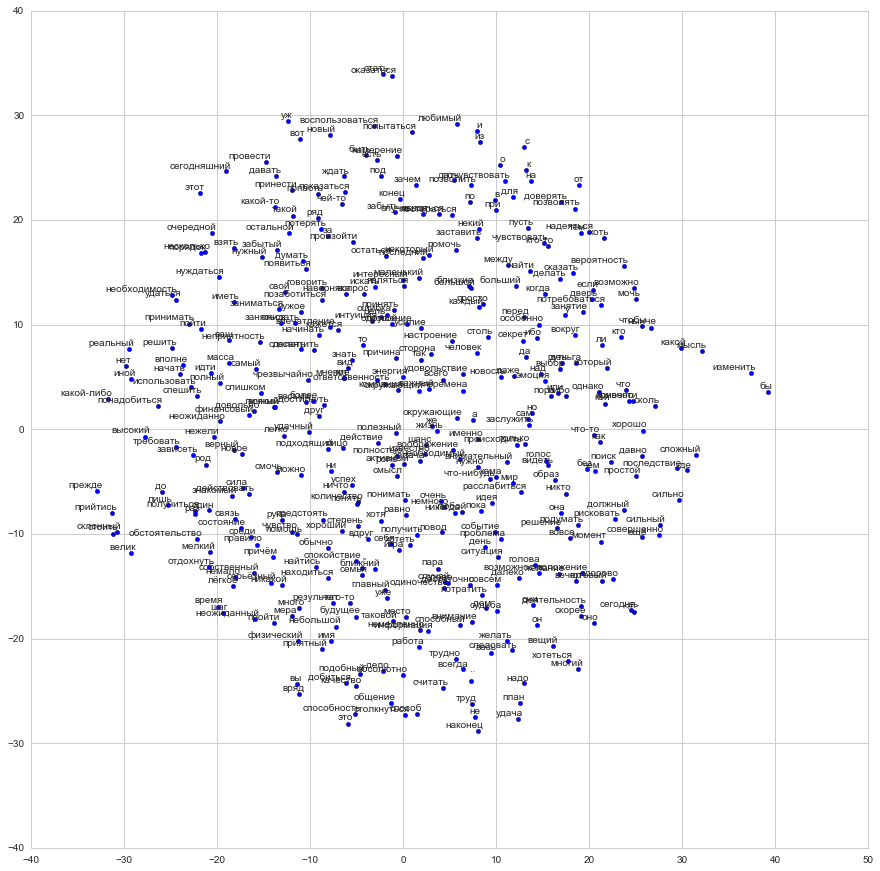

In [12]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [index_to_word[i] for i in range(1, num_points+1)]
plot(my_two_d_embeddings, words)

LSTM
---

In [13]:
class BatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()
  
    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size), dtype=np.int32)
        for b in range(self._batch_size):
            batch[b] = self._text[self._cursor[b]]
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
  
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

In [14]:
def logprob(predictions, labels):
    true = np.zeros_like(predictions, dtype=np.float)
    for i in range(len(labels)):
        true[i, labels[i]] = 1.0
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(true, -np.log(predictions))) / true.shape[0]

def perplexity(predictions, labels):
    return np.exp(logprob(predictions, labels))

In [15]:
valid_size = 500
trunc_by = 10
batch_size = 64
valid_dataset = data[:valid_size]
train_dataset = data[valid_size:]

train_batches = BatchGenerator(train_dataset, batch_size, trunc_by)
valid_batches = BatchGenerator(valid_dataset, 1, 1)

Loss function:
$$\mathcal{L} = - \sum\limits_{k = 1}^N y_k \log o_k$$

Output at step $k$:
$$o_k = softmax(H_k \ast W_{(sm)}^k + b_{(sm)}^k) = \frac{\exp \{H_k \ast W_{(sm)}^k + b_{(sm)}^k\}}{\sum\limits_{n=1}^N \exp \{H_n \ast W_{(sm)}^n + b_{(sm)}^n\}}$$

Hidden state at step $k$:
$$H_k = output\_gate(w_k, H_{k-1}) \cdot \tanh (state_k \ast W_{(h)} + b_{(h)})$$

Cell state at step $k$:
$$state_k = forget\_gate \cdot state_{k-1} + input\_gate \cdot \tanh ([w_k, h_{k-1}] \ast W_{(c)} + b_{(c)})$$

Output gate function for step $k$:
$$output\_gate(w_k, H_{k-1}) = \sigma([w_k, h_{k-1}] W_{(o)} + b_{(o)})$$

Forget gate function for step $k$:
$$forget\_gate(w_k, H_{k-1}) = \sigma([w_k, h_{k-1}] W_{(f)} + b_{(f)})$$

Input gate function for step $k$:
$$output\_gate(w_k, H_{k-1}) = \sigma([w_k, h_{k-1}] W_{(i)} + b_{(i)})$$

In [16]:
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data
    train_data = [tf.placeholder(tf.int32, shape=[batch_size]) for i in range(trunc_by+1)]
    train_inputs = train_data[:-1]
    train_labels = train_data[1:]
    embeddings = tf.constant(final_embeddings)

    # Variables
    # Input gate
    input_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1))
    input_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1))
    # Forget gate
    forget_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1))
    forget_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1))
    # State cell
    cell_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1))
    cell_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1))
    # Hidden state updates
    hidden_weights = tf.Variable(tf.truncated_normal([embedding_size, embedding_size], -0.1, 0.1))
    hidden_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1))
    # Output gate
    output_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1))
    output_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1))
    # Connections
    saved_state = tf.Variable(tf.truncated_normal([batch_size, embedding_size], -0.1, 0.1))
    saved_h = tf.Variable(tf.truncated_normal([batch_size, embedding_size], -0.1, 0.1))
    # Softmax
    softmax_weights = tf.Variable(tf.truncated_normal([embedding_size, vocabulary_size]))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # For saving purpose
    tf.add_to_collection('vars', input_weights)
    tf.add_to_collection('vars', input_biases)
    tf.add_to_collection('vars', forget_weights)
    tf.add_to_collection('vars', forget_biases)
    tf.add_to_collection('vars', cell_weights)
    tf.add_to_collection('vars', cell_biases)
    tf.add_to_collection('vars', hidden_weights)
    tf.add_to_collection('vars', hidden_biases)
    tf.add_to_collection('vars', output_weights)
    tf.add_to_collection('vars', output_biases)
    tf.add_to_collection('vars', saved_state)
    tf.add_to_collection('vars', saved_h)
    tf.add_to_collection('vars', softmax_weights)
    tf.add_to_collection('vars', softmax_biases)
    
    saver = tf.train.Saver()
    
    # Cell
    def lstm_cell(w, h, state):
        i = tf.concat([w, h], 1)
        input_gate = tf.sigmoid(tf.matmul(i, input_weights) + input_biases)
        forget_gate = tf.sigmoid(tf.matmul(i, forget_weights) + forget_biases)
        output_gate = tf.sigmoid(tf.matmul(i, output_weights) + output_biases)
        state_update = tf.tanh(tf.matmul(i, cell_weights) + cell_biases)
        state = forget_gate * state + input_gate * state_update
        state_update = tf.tanh(tf.matmul(state, hidden_weights) + hidden_biases)
        h = output_gate * state_update
        return h, state

    # Model
    hs = []
    h = saved_h
    state = saved_state
    for w in train_inputs:
        e = tf.nn.embedding_lookup(embeddings, w)
        h, state = lstm_cell(e, h, state)
        hs.append(h)
        
    with tf.control_dependencies([saved_h.assign(h), saved_state.assign(state)]):
        logits = tf.nn.xw_plus_b(tf.concat(hs, 0), softmax_weights, softmax_biases)
        true = tf.one_hot(indices=tf.concat(train_labels, 0), depth=vocabulary_size)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.concat(true, 0), logits=logits))
    
    # Optimizer
    gs = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(10., gs, 10000, 0.1, staircase=False)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    
    # Gradients
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=gs)

    # Prediction
    train_prediction = tf.nn.softmax(logits)
    
    # Evaluation
    sample_input = tf.placeholder(tf.int32, [1])
    saved_sample_h = tf.Variable(tf.zeros([1, embedding_size]))
    saved_sample_state = tf.Variable(tf.zeros([1, embedding_size]))
    
    sample_embedding = tf.nn.embedding_lookup(embeddings, sample_input)
    reset_sample_state = tf.group(saved_sample_h.assign(tf.zeros([1, embedding_size])),
                                  saved_sample_state.assign(tf.zeros([1, embedding_size])))
    
    sample_h, sample_state = lstm_cell(sample_embedding, saved_sample_h, saved_sample_state)
    with tf.control_dependencies([saved_sample_h.assign(sample_h), saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_h, softmax_weights, softmax_biases))

In [17]:
num_steps = 20001
print_every = 500

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        labels = np.concatenate(batches[1:])
        feed_dict = {}
        for i in range(trunc_by + 1):
            feed_dict[train_data[i]] = batches[i]

        opt, l, pred, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        average_loss += l
        if step % print_every == 0:
            if step > 0:
                average_loss = average_loss / print_every
            print 'Average loss at step %d: %.2f learning rate: %.2f' % (step, average_loss, lr)
            average_loss = 0
            labels = np.concatenate(batches[1:])
            print 'Minibatch perplexity: %e' % perplexity(pred, labels)
                  
            if (step % (print_every * 5)) == 0:
                sym = word_to_index['<$>']
                reset_sample_state.run()
                iter_num = 0
                tweet = []
                while sym != word_to_index['<#>'] and iter_num < 40:
                    prediction = sample_prediction.eval({sample_input: np.array([sym])})
                    prediction = np.argmax(prediction)
                    tweet.append(index_to_word[prediction])
                    sym = prediction
                    iter_num += 1
                print '=' * 100
                print ' '.join(tweet[:-1])
                print '=' * 100
                
                saver.save(session, './Model/model', global_step=step)
            
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            print 'Validation set perplexity: %e\n' % np.exp(valid_logprob / valid_size)

Initialized
Average loss at step 0: 49.97 learning rate: 10.00
Minibatch perplexity: 9.168183e+09
неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый <$> неотразимый
Validation set perplexity: 7.327649e+09

Average loss at step 500: 53.39 learning rate: 8.91
Minibatch perplexity: 8.254696e+06
Validation set perplexity: 1.716988e+09

Average loss at step 1000: 47.17 learning rate: 7.94
Minibatch perplexity: 2.371372e+09
Validation set perplexity: 1.361369e+07

Average loss at step 1500: 41.51 learning rate: 7.08
Minibatch perplexity: 1.649100e+06
Validation set perplexity: 1.941813e+09

Average loss at step 2000: 37.63 learning rate: 6.31
Minibatch perplexity: 3.086543e+08
Validation set perplexity: 6.065277e+06

Average loss at step 2500: 32.

Restore model